**Dataset Information**

|Feature|Feature_Type|Description|
|-----|-----|-----|
|age|numeric|age of a person|  
|job |Categorigol,nominal|type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')|  
|marital|categorical,nominal|marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)|  
|education|categorical,nominal| ('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | 
|default|categorical,nominal| has credit in default? ('no','yes','unknown')|  
|housing|categorical,nominal| has housing loan? ('no','yes','unknown')|  
|loan|categorical,nominal| has personal loan? ('no','yes','unknown')|  
|contact|categorical,nominal| contact communication type ('cellular','telephone')|  
|month|categorical,ordinal| last contact month of year ('jan', 'feb', 'mar', ..., 'nov', 'dec')| 
|day_of_week|categorical,ordinal| last contact day of the week ('mon','tue','wed','thu','fri')|  
|duration|numeric| last contact duration, in seconds . Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no')|
|campaign|numeric|number of contacts performed during this campaign and for this client (includes last contact)|  
|pdays|numeric| number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)|  
|previous|numeric| number of contacts performed before this campaign and for this client|  
|poutcome|categorical,nominal| outcome of the previous marketing campaign ('failure','nonexistent','success')|  
|emp.var.rate|numeric|employment variation rate - quarterly indicator|  
|cons.price.idx|numeric| consumer price index - monthly indicator|  
|cons.conf.idx|numeric| consumer confidence index - monthly indicator|  
|euribor3m|numeric|euribor 3 month rate - daily indicator|
|nr.employed|numeric| number of employees - quarterly indicator|   

**Target variable (desired output):**  

|Feature|Feature_Type|Description|
|-----|-----|-----|
|y | binary| has the client subscribed a term deposit? ('yes','no')|

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data modelling libraries
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
from scipy.stats.mstats import winsorize
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',None)

In [4]:
df = pd.read_csv('train.csv', delimiter=',')
df.head()

,Id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,25611,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
1,26010,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no
2,40194,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1.7,94.215,-40.3,0.870,4991.6,yes
3,297,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,36344,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,no


## Data Preprocesssing

In [5]:
df.drop('Id',axis=1, inplace=True)

In [6]:
print('Shape of the data is:', df.shape)

Shape of the data is: (32950, 21)


### Checking Numeric & Categorical features

Looking at the dataset, we think we can identify the categorical and continuous columns in it. Right? But it might also be possible that the numerical values are represented as strings in some feature. Or the categorical values in some features might be represented as some other datatypes instead of strings. Hence it's good to check for the datatypes of all the features.


In [10]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [34]:
# Identifying numeric features
numeric = df.select_dtypes(include=np.number).columns.tolist()
print('Numeric features-')
print('----------------')
print(df[numeric].head())

Numeric features-
----------------
   age  duration  campaign  emp.var.rate  cons.price.idx  cons.conf.idx  \
0   49       227         4          -0.1          93.200          -42.0   
1   37       202         2          -0.1          93.200          -42.0   
2   55       550         1          -1.7          94.215          -40.3   
3   36       120         2           1.1          93.994          -36.4   
4   55       368         2          -2.9          92.963          -40.8   

   euribor3m  nr.employed  
0      4.120       5195.8  
1      4.120       5195.8  
2      0.870       5008.7  
3      4.857       5191.0  
4      1.262       5076.2  


In [35]:
# Identifying categorical features
cate = df.select_dtypes(exclude=np.number).columns.tolist()
print('Categorical features-')
print('--------------------')
print(df[cate].head())

Categorical features-
--------------------
            job   marital          education default housing loan    contact  \
0   blue-collar   married           basic.9y      no      no   no   cellular   
1  entrepreneur   married  university.degree      no      no   no  telephone   
2       retired   married           basic.4y      no      no   no   cellular   
3        admin.   married  university.degree      no     yes   no  telephone   
4       retired  divorced  university.degree      no      no   no   cellular   

  month day_of_week     poutcome    y  
0   nov         wed  nonexistent   no  
1   nov         wed      failure   no  
2   jul         mon  nonexistent  yes  
3   may         mon  nonexistent   no  
4   jun         tue  nonexistent   no  


### Checking Missing Data

In [11]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Check for Class Imbalance

<AxesSubplot:xlabel='y', ylabel='count'>

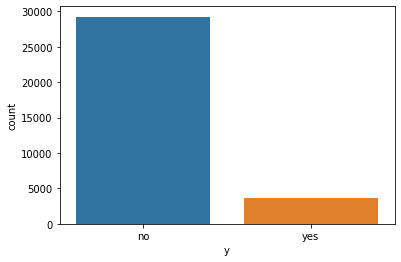

In [14]:
sns.countplot(df['y'])

In [16]:
values = (df['y'].value_counts()/df['y'].value_counts().sum())*100
print(values)

no     88.734446
yes    11.265554
Name: y, dtype: float64


- The class distribution in the target is ~89:11. 
- This is clearly an imbalance data

### Outlier detection

In [19]:
cols = list(df)
outliers = pd.DataFrame(columns=['Feature','No. of Outliers'])

for column in cols: # iterate through all columns
    if column in df.select_dtypes(include=np.number).columns: # checking for nummeric data
        
        q1 = df[column].quantile(0.25) # first quartile Q1
        q3 = df[column].quantile(0.75) # third quartile Q3
        
        iqr = q3 - q1 # IQR
        
        range_low = q1 - (1.5*iqr)
        range_high = q3 + (1.5*iqr)
        
        outliers = outliers.append({'Feature': column, 'No. of Outliers': df.loc[(df[column] < range_low) | (df[column] > range_high)].shape[0]},ignore_index=True)
outliers

,Feature,No. of Outliers
0,age,368
1,duration,2366
2,campaign,1916
3,pdays,1226
4,previous,4534
5,emp.var.rate,0
6,cons.price.idx,0
7,cons.conf.idx,359
8,euribor3m,0
9,nr.employed,0


## EDA & Data Visualization

### Univariate Analysis

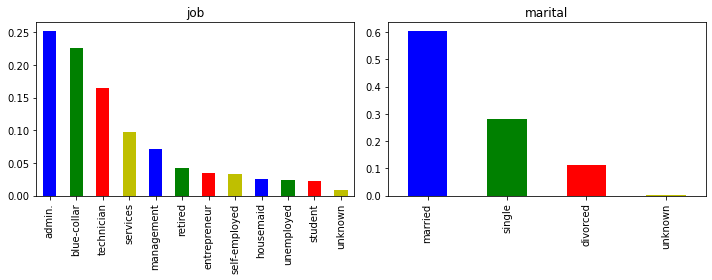

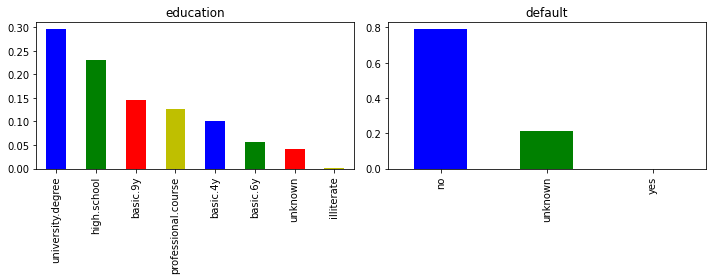

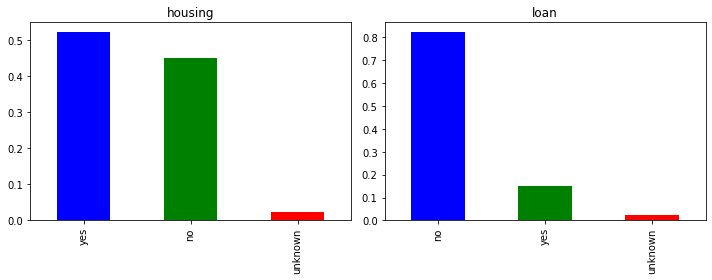

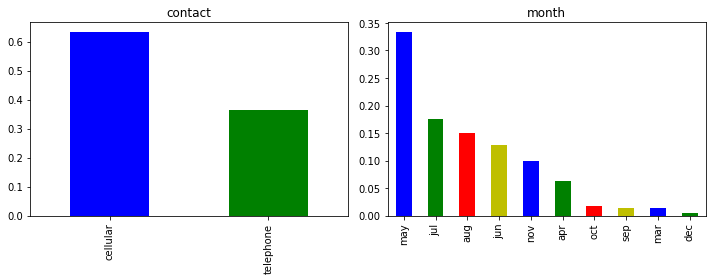

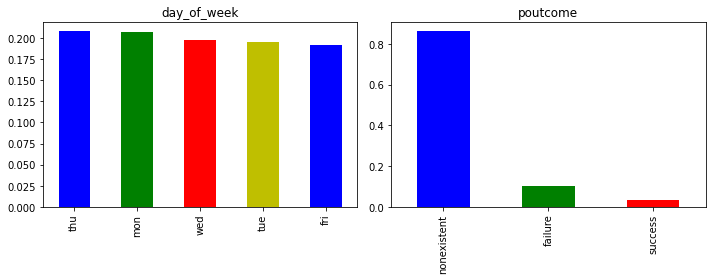

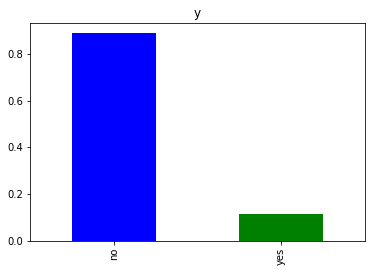

In [24]:
# Univariate analysis of Categorical columns

categorical_columns = df.select_dtypes(include=['object']).columns
    
for i in range(0,len(categorical_columns),2):
        if len(categorical_columns) > i+1:
                
                plt.figure(figsize=(10,4))
                plt.subplot(121)
                df[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar', color=['b','g','r','y'])
                plt.title(categorical_columns[i])
                plt.subplot(122)     
                df[categorical_columns[i+1]].value_counts(normalize=True).plot(kind='bar',color=['b','g','r','y'])
                plt.title(categorical_columns[i+1])
                plt.tight_layout()
                plt.show()

        else:
                df[categorical_columns[i]].value_counts(normalize=True).plot(kind='bar',color=['b','g','r','y'])
                plt.title(categorical_columns[i])

From the above visuals, we can make the following observations: 

- The top three professions that our customers belong to are - administration, blue-collar jobs and technicians.
- A huge number of the customers are married.
- Many of our past customers have applied for a housing loan but very few have applied for personal loans.
- Cell-phones seem to be the most favoured method of reaching out to customers.
- Many customers have been contacted in the month of May.
- The plot for the target variable shows heavy imbalance in the target variable. 
- The missing values in some columns have been represented as ~unknown`. `unknown` represents missing data. In the next task, we will treat these values.  

In [27]:
# Replace missing value of Categorical data with Mode
cols = list(df)

for col in cols:
    if col in df.select_dtypes(exclude=np.number).columns:
        df[col] = df[col].str.replace('unknown',df[col].mode()[0])

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,49,blue-collar,married,basic.9y,no,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,-0.1,93.200,-42.0,4.120,5195.8,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1.7,94.215,-40.3,0.870,4991.6,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-2.9,92.963,-40.8,1.262,5076.2,no


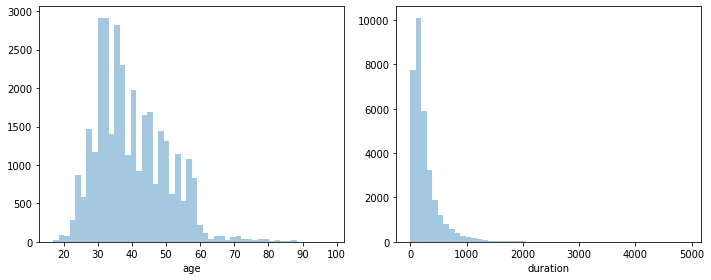

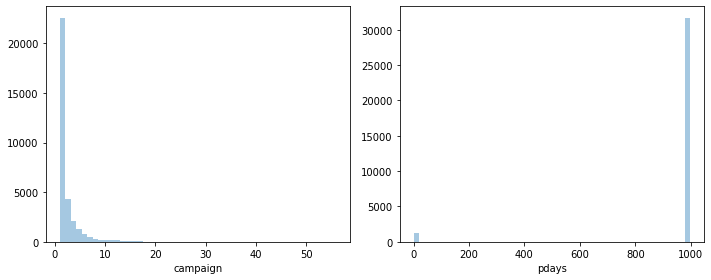

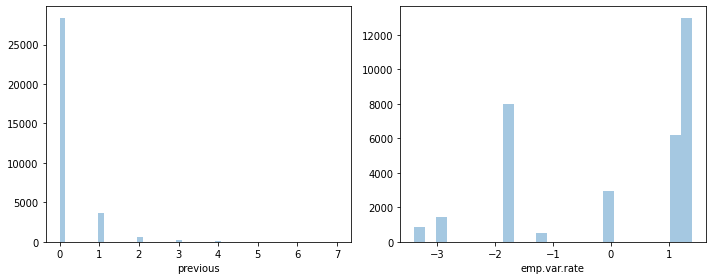

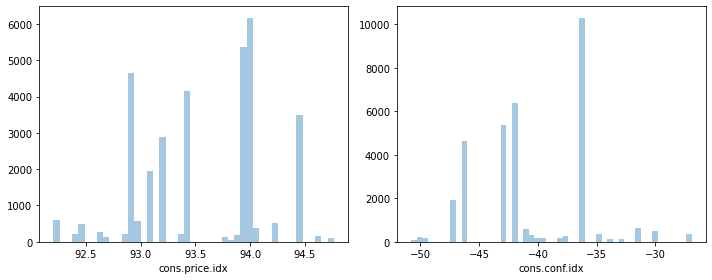

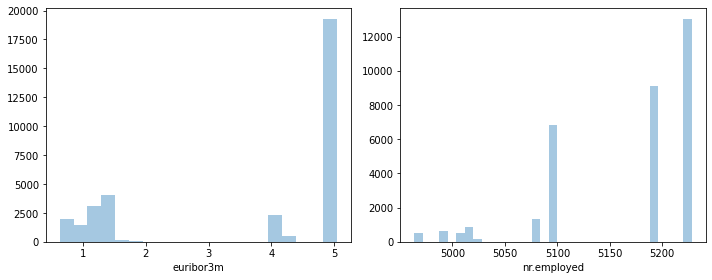

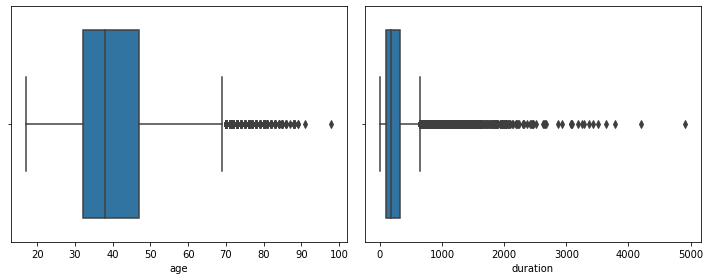

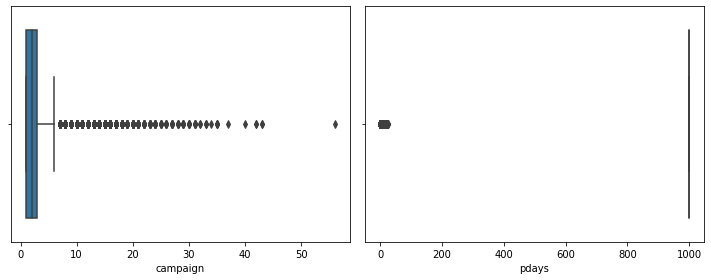

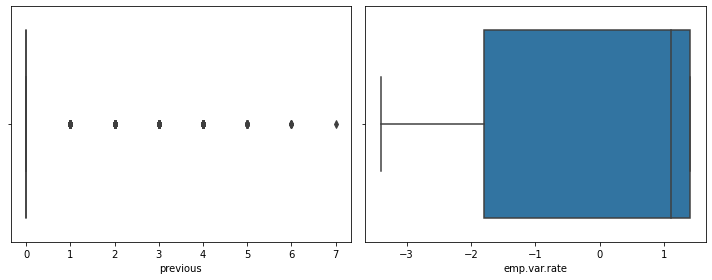

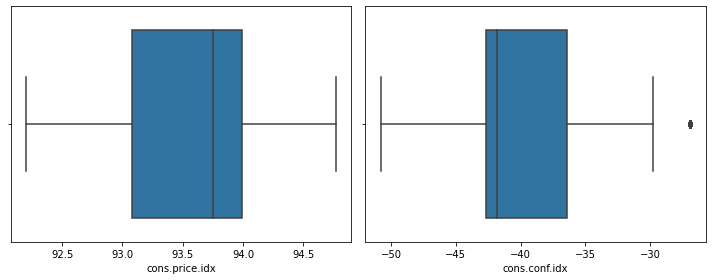

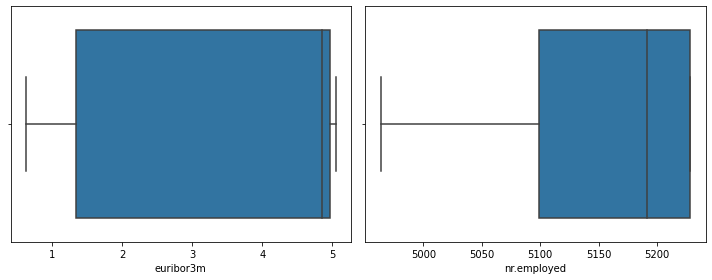

In [28]:
# Univariate analysis of Numeric columns

numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    
for i in range(0,len(numeric_columns),2):
    if len(numeric_columns) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.distplot(df[numeric_columns[i]], kde=False)
        plt.subplot(122)            
        sns.distplot(df[numeric_columns[i+1]], kde=False)
        plt.tight_layout()
        plt.show()

    else:
        sns.distplot(df[numeric_columns[i]], kde=False)

# Code to plot boxplots
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
    
for i in range(0,len(numeric_columns),2):
    if len(numeric_columns) > i+1:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.boxplot(df[numeric_columns[i]])
        plt.subplot(122)            
        sns.boxplot(df[numeric_columns[i+1]])
        plt.tight_layout()
        plt.show()

    else:
        sns.boxplot(df[numeric_columns[i]])

- As we can see from the histogram, the features `age`, `duration` and `campaign` are heavily skewed and this is due to the presence of outliers as seen in the boxplot for these features.
- Looking at the plot for `pdays`, we can infer that majority of the customers were being contacted for the first time for `pdays`. The value 999 indicates that the customer had not been contacted previously. 

In [29]:
# Since the features `pdays` and `previous` consist majorly only of a single value, their variance is quite less 
# and hence we can drop them since technically will be of no help in prediction.

df.drop(['pdays','previous'], axis=1, inplace=True)

### Bivariate Analysis

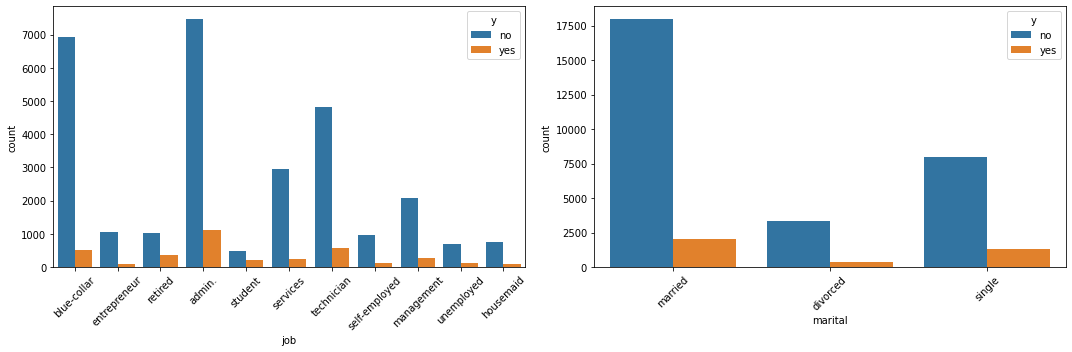

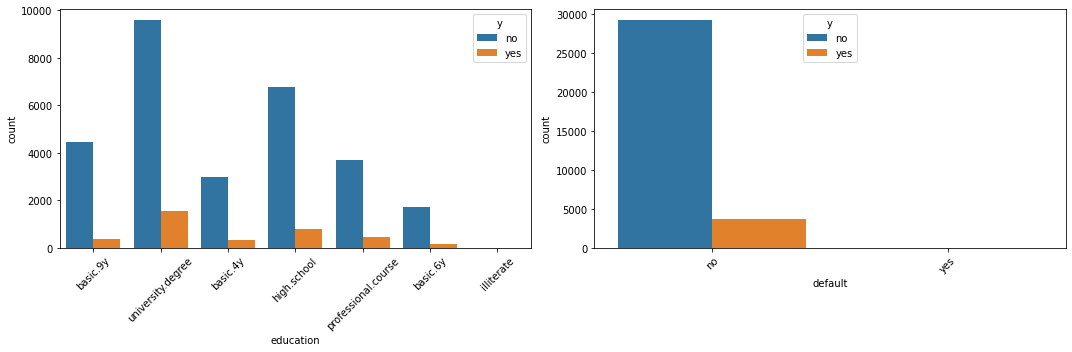

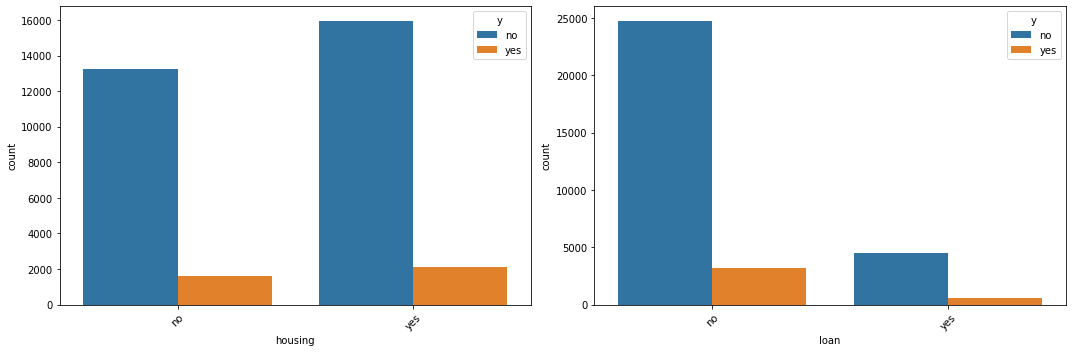

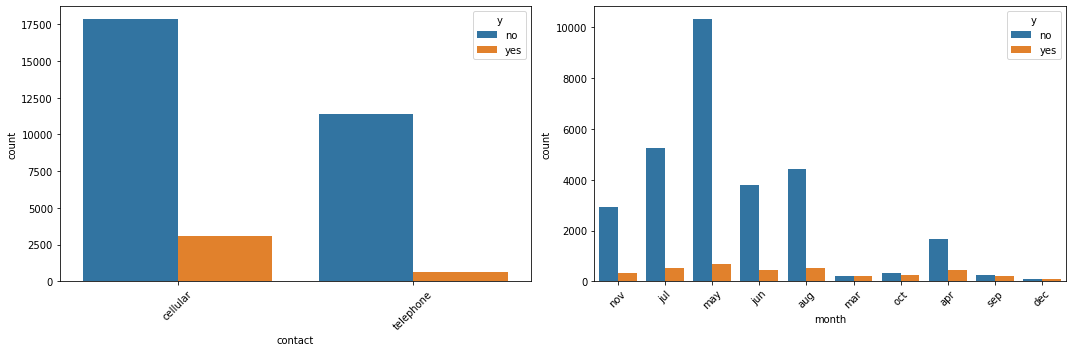

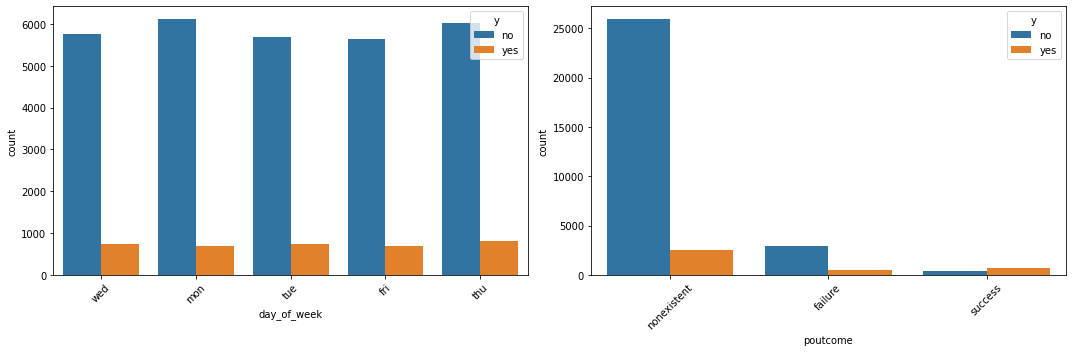

In [30]:
categorical_columns = df.select_dtypes(exclude=np.number).columns
for i in range(0,len(categorical_columns),2):
    if len(categorical_columns) > i+1:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.countplot(x=df[categorical_columns[i]],hue=df['y'],data=df)
        plt.xticks(rotation=45)
        plt.subplot(122)            
        sns.countplot(df[categorical_columns[i+1]],hue=df['y'],data=df)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


The common traits seen for customers who have subscribed for the term deposit are :
   - Customers having administrative jobs form the majority amongst those who have subscirbed to the term deposit with technicians being the second majority.
   - They are married 
   - They hold a university degree
   - They do not hold a credit in default
   - Housing loan doesn't seem a priority to check for since an equal number of customers who have and have not subscribed to it seem to have subscribed to the term deposit.
   - Cell-phones should be the preferred mode of contact for contacting customers.

### Treating the Outliers

Hence for this data we use a method called *Winsorization*.<br/>
In this method we define a confidence interval of let's say 90% and then replace all the outliers below the 5th percentile with the value at 5th percentile and all the values above 95th percentile with the value at the 95th percentile.<br/>
It is pretty useful when there are negative values and zeros in the features which cannot be treated with log transforms or square roots.

In [31]:
cols = list(df)
for col in cols:
    if col in df.select_dtypes(include=np.number).columns:
        df[col] = winsorize(df[col], limits=[0.05, 0.1],inclusive=(True, True))

In [32]:
cols = list(df)
outliers = pd.DataFrame(columns=['Feature','No. of Outliers'])

for column in cols: # iterate through all columns
    if column in df.select_dtypes(include=np.number).columns: # checking for nummeric data
        
        q1 = df[column].quantile(0.25) # first quartile Q1
        q3 = df[column].quantile(0.75) # third quartile Q3
        
        iqr = q3 - q1 # IQR
        
        range_low = q1 - (1.5*iqr)
        range_high = q3 + (1.5*iqr)
        
        outliers = outliers.append({'Feature': column, 'No. of Outliers': df.loc[(df[column] < range_low) | (df[column] > range_high)].shape[0]},ignore_index=True)
outliers

,Feature,No. of Outliers
0,age,0
1,duration,0
2,campaign,0
3,emp.var.rate,0
4,cons.price.idx,0
5,cons.conf.idx,0
6,euribor3m,0
7,nr.employed,0


## Model Selection
### (This is done without Hyperparameter Tuning. Just to see how the model performs)

Algorathims used are:
- Logistic Regression
- DecisionTree Classifier
- RandomForest Classfier
- XGBClassifier
- GradientBoostingClassifier

### Label Encoding of Categorical Column

In [36]:
# Initialize label encoder
le = LabelEncoder()
columnsToEncode = list(df.select_dtypes(include=['category','object']))

for feature in columnsToEncode:
    try:
        df[feature] = le.fit_transform(df[feature])
    except:
        print('Error encoding '+feature)

In [37]:
x = df.iloc[:,:-1] # independent features
y = df.iloc[:,-1] # dependent features

In [38]:
# Training and testing the data
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [39]:
len(X_train), len(X_test)

(26360, 6590)

### Logistic Regression

In [40]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [41]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5798
           1       0.60      0.34      0.43       792

    accuracy                           0.89      6590
   macro avg       0.76      0.65      0.69      6590
weighted avg       0.88      0.89      0.88      6590

ROC_AUC_SCORE is 0.6524066989313626


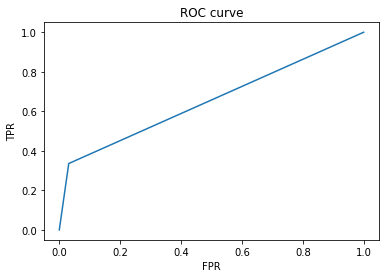

In [42]:
# roc_auc curve
auc = roc_auc_score(y_test,y_pred)
print('Classification Report')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
print('ROC_AUC_SCORE is',roc_auc_score(y_test,y_pred))

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### Decision Tree

In [43]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [44]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5798
           1       0.51      0.52      0.52       792

    accuracy                           0.88      6590
   macro avg       0.72      0.73      0.72      6590
weighted avg       0.88      0.88      0.88      6590

ROC_AUC_SCORE is 0.7257511733408595


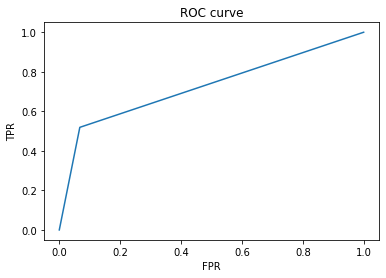

In [45]:
# roc_auc curve
auc = roc_auc_score(y_test,y_pred)
print('Classification Report')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
print('ROC_AUC_SCORE is',roc_auc_score(y_test,y_pred))

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### Random Forest

In [46]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [47]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5798
           1       0.63      0.47      0.54       792

    accuracy                           0.90      6590
   macro avg       0.78      0.72      0.74      6590
weighted avg       0.89      0.90      0.90      6590

ROC_AUC_SCORE is 0.7169389218156035


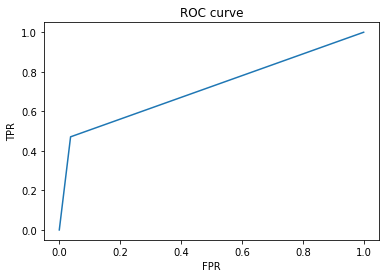

In [48]:
# roc_auc curve
auc = roc_auc_score(y_test,y_pred)
print('Classification Report')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
print('ROC_AUC_SCORE is',roc_auc_score(y_test,y_pred))

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### XGBoost

In [49]:
model = XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      5798
           1       0.62      0.51      0.56       792

    accuracy                           0.90      6590
   macro avg       0.78      0.73      0.75      6590
weighted avg       0.90      0.90      0.90      6590

ROC_AUC_SCORE is 0.7346400796512903


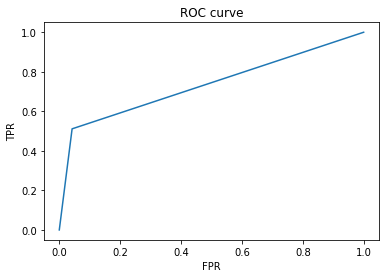

In [51]:
# roc_auc curve
auc = roc_auc_score(y_test,y_pred)
print('Classification Report')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
print('ROC_AUC_SCORE is',roc_auc_score(y_test,y_pred))

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### Gradient Boosting 

In [52]:
model = GradientBoostingClassifier()
model.fit(X_train,y_train)

GradientBoostingClassifier()

In [53]:
y_pred = model.predict(X_test)

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5798
           1       0.65      0.44      0.52       792

    accuracy                           0.90      6590
   macro avg       0.79      0.70      0.73      6590
weighted avg       0.89      0.90      0.90      6590

ROC_AUC_SCORE is 0.7021356197365166


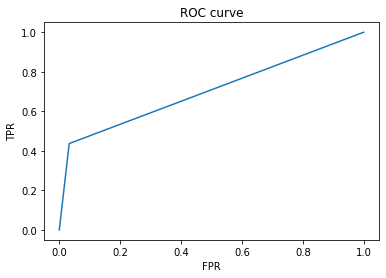

In [54]:
# roc_auc curve
auc = roc_auc_score(y_test,y_pred)
print('Classification Report')
print(classification_report(y_test,y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred)
print('ROC_AUC_SCORE is',roc_auc_score(y_test,y_pred))

plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Feature Selection

Let's now use feature selection methods for identifying the best set of features for each model.

###  Using RFE for feature selection

In this task lets use Recursive Feature Elimination for selecting the best features. RFE is a method that uses the model to identify the best features. 



In [59]:
# selecting models
models = LogisticRegression()
# using  rfe and selecting top 8 features
rfe = RFE(models,8)

rfe = rfe.fit(x,y)

feature_ranking = pd.Series(rfe.ranking_, index=x.columns)
plt.show()
print('Top 8 features of Logistic Regression model are:')
print(feature_ranking[feature_ranking.values==1].index.tolist())
print('===='*30)

Top 8 features of Logistic Regression model are:
['marital', 'contact', 'day_of_week', 'campaign', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'euribor3m']


In [60]:
# selecting models
models = RandomForestClassifier()
# using  rfe and selecting top 8 features
rfe = RFE(models,8)

rfe = rfe.fit(x,y)

feature_ranking = pd.Series(rfe.ranking_, index=x.columns)
plt.show()
print('Top 8 features of Logistic Regression model are:')
print(feature_ranking[feature_ranking.values==1].index.tolist())
print('===='*30)

Top 8 features of Logistic Regression model are:
['age', 'job', 'education', 'day_of_week', 'duration', 'poutcome', 'euribor3m', 'nr.employed']


In [61]:
# selecting models
models = XGBClassifier()
# using  rfe and selecting top 8 features
rfe = RFE(models,8)

rfe = rfe.fit(x,y)

feature_ranking = pd.Series(rfe.ranking_, index=x.columns)
plt.show()
print('Top 8 features of Logistic Regression model are:')
print(feature_ranking[feature_ranking.values==1].index.tolist())
print('===='*30)

Top 8 features of Logistic Regression model are:
['contact', 'duration', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


## Hyperparameter Tuning

### Random Forest

In [62]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42, stratify=y)

rfc = RandomForestClassifier()

params = { 
'max_features': ['auto', 'sqrt', 'log2'],
'max_depth' : [4,5,6,7,8],
'criterion' :['gini', 'entropy']
             }


rfc_grid = GridSearchCV(rfc, param_grid=params)
rfc_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2']})

In [63]:
rfc_grid.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}

              precision    recall  f1-score   support

           0       0.98      0.86      0.91      8723
           1       0.44      0.85      0.58      1162

    accuracy                           0.85      9885
   macro avg       0.71      0.85      0.74      9885
weighted avg       0.91      0.85      0.87      9885

[[7462 1261]
 [ 179  983]]


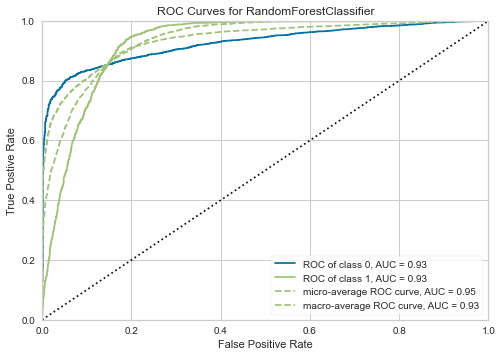

In [68]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import roc_auc


def grid_search_random_forest_best(dataframe,target):
    
    X_train,X_test,y_train,y_test = train_test_split(dataframe,target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE()  
    x_sm, y_sm =  smote.fit_sample(X_train, y_train)
    
    rfc = RandomForestClassifier(n_estimators=11, max_features='auto', max_depth=8, criterion='entropy',random_state=42)
    
    rfc.fit(x_sm, y_sm)
    y_pred = rfc.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    # using visualizer
    visualizer = roc_auc(rfc,x_sm,y_sm,X_test,y_test)


grid_search_random_forest_best(x,y)

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      8723
           1       0.43      0.89      0.58      1162

    accuracy                           0.85      9885
   macro avg       0.71      0.87      0.74      9885
weighted avg       0.92      0.85      0.87      9885

[[7348 1375]
 [ 126 1036]]


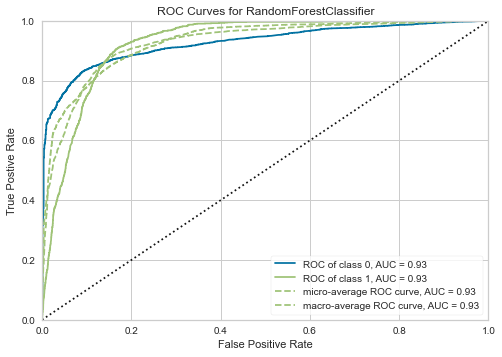

In [70]:
# Using top 8 features that we found from feature selection
grid_search_random_forest_best(x[['age', 'job', 'education', 'day_of_week', 'duration', 'poutcome', 'euribor3m', 'nr.employed']],y)

- Using Feature Selection, recall value increase from 0.85 to 0.89
- 4% increase in accuracy

### Logestic Regression

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      8723
           1       0.38      0.89      0.53      1162

    accuracy                           0.82      9885
   macro avg       0.68      0.85      0.71      9885
weighted avg       0.91      0.82      0.84      9885

[[7040 1683]
 [ 131 1031]]


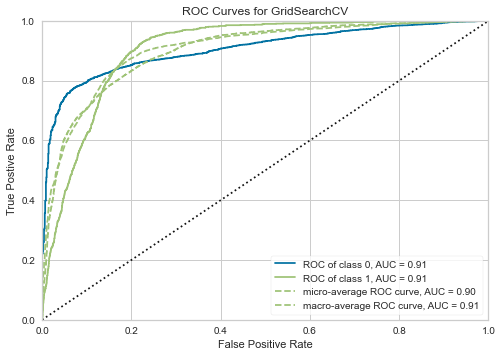

In [73]:
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Initializing smote
smote = SMOTE()
x_sm, y_sm =  smote.fit_sample(X_train, y_train)

lr = LogisticRegression()

params = { 
        'C' : np.logspace(-5, 8, 15)
            }

lr_grid = GridSearchCV(lr, param_grid=params)
lr_grid.fit(x_sm, y_sm)

y_pred = lr_grid.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# using visualizer
visualizer = roc_auc(lr_grid,x_sm,y_sm,X_test,y_test)

### XGBoost


              precision    recall  f1-score   support

           0       0.97      0.89      0.93      8723
           1       0.48      0.77      0.59      1162

    accuracy                           0.87      9885
   macro avg       0.72      0.83      0.76      9885
weighted avg       0.91      0.87      0.89      9885

[[7751  972]
 [ 272  890]]


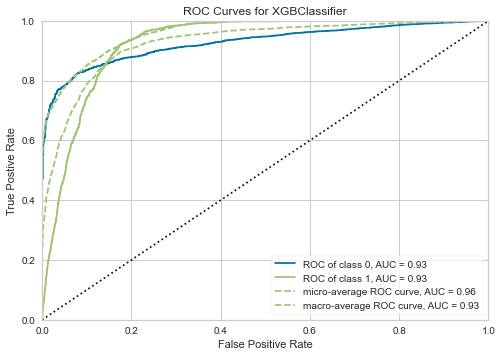

In [77]:
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# initializing smote
smote = SMOTE()
x_sm, y_sm =  smote.fit_sample(X_train, y_train)

model = XGBClassifier(n_estimators=50, max_depth=4)
model.fit(pd.DataFrame(x_sm,columns=X_train.columns), y_sm)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# using visualizer to 
visualizer = roc_auc(model,x_sm,y_sm,X_test,y_test)

### Observation:

From the above 3 Models used, we can say that *XGBoost* is the best model and has performed excellent because-
1. It has the least 'False Positive' & 'False Negative' rate
2. Highest Recall and maximum f1-score amongst all